# Training of UNET

The aim of this notebook is to train two times the UNET model, once using the training data with simple data augmentations (rotation by multiples of 90 degrees, horizontal and vertical flips), and the second time with said data augmentation and distortions added to the training data (non-uniform illumination and gaussian noise).

### $\bullet$ Importing libraries and utilitary functions

In [1]:
# Import python libraries.
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%load_ext autoreload
%autoreload 2
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Import utilitary functions and module defining the Unet model.
from utils import get_dataset_from_folders
from train_data_augmentation import make_train_generator
import model
from distortions import add_gaussian, add_gaussian_noise
from plots import plot_history

In [2]:
# Set seeds of random number generators to guarantee reproducibility.
np.random.seed(100)
tensorflow.random.set_seed(200)

### $\bullet$ Setting size of the input image and different paths

In [3]:
# To improve training: add data augmentation to the pipeline: for vanilla one, make function that does random rotation by 90 degrees, horizontal-vertical flip. It would be called before every batch is used for training
# Also to improve training: try doing learning rate scheduling such as cyclic learning rate scheduling



# Shape of the inputs of the deep network.
images_shape = (256, 256, 1)

# Variables defining the path to the dataset.
train_input_path = '../Dataset/train/input/'
train_output_path = '../Dataset/train/output/'
val_input_path = '../Dataset/validation/input/'
val_output_path = '../Dataset/validation/output/'
test_input_path = '../Dataset/test/input/'
test_output_path = '../Dataset/test/output/'

# Variable defining where models will be stored.
model_original_save_path = "../Model Original/"
model_retrained_save_path = "../Model Retrained/"

### $\bullet$ Load images from the dataset

In [4]:
train_images, train_masks = get_dataset_from_folders(train_input_path, train_output_path, images_shape)
val_images, val_masks = get_dataset_from_folders(val_input_path, val_output_path, images_shape)
test_images, test_masks = get_dataset_from_folders(test_input_path, test_output_path, images_shape)

print(f'Training set contains {len(train_images)} images.')
print(f'Validation set contains {len(val_images)} images.')
print(f'Test set contains {len(test_images)} images.')

Training set contains 606 images.
Validation set contains 96 images.
Test set contains 510 images.


### $\bullet$ Choose training parameters and build model

In [5]:
# Setting up parameters used for training
number_epochs = 200
batch_size = 8
steps_per_epoch = np.ceil(len(train_images)/batch_size).astype(np.uint)
early_stopping = EarlyStopping(patience=80, verbose=1)
model_checkpoint = ModelCheckpoint(filepath=model_original_save_path, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)

# Building Unet model.
unet = model.unet(images_shape, show_summary=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

### Training model using images with simple data augmentations and no distortions

In [6]:
# Training
train_generator = make_train_generator(train_images, train_masks, batch_size=batch_size, custom_distortions=False)
history = unet.fit(train_generator, validation_data=(val_images, val_masks), steps_per_epoch=steps_per_epoch, batch_size=batch_size, epochs=number_epochs, callbacks=[early_stopping, model_checkpoint])

  ...
    to  
  ['...']
Train for 76 steps, validate on 96 samples
Epoch 1/200
75/76 [============================>.] - ETA: 0s - loss: 1.4697 - accuracy: 0.8531WARNING:tensorflow:From C:\Anaconda3\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../Model Original/assets
76/76 [==============================] - 24s 319ms/step - loss: 1.4545 - accuracy: 0.8537 - val_loss: 0.3672 - val_accuracy: 0.9095
Epoch 2/200
76/76 [==============================] - 18s 235ms/step - loss: 0.2519 - accuracy: 0.9206 - val_loss: 0.1151 - val_accuracy: 0.9487
Epoch 3/200
76/76 [==============================] - 19s 250ms/step - loss: 0.1198 - accuracy: 0.9514 - val_loss: 0.0696 - val_accuracy: 0.9728
Epoc

76/76 [==============================] - 15s 201ms/step - loss: 0.0302 - accuracy: 0.9874 - val_loss: 0.0453 - val_accuracy: 0.9851
Epoch 36/200
76/76 [==============================] - 15s 200ms/step - loss: 0.0296 - accuracy: 0.9877 - val_loss: 0.0436 - val_accuracy: 0.9858
Epoch 37/200
76/76 [==============================] - 15s 200ms/step - loss: 0.0289 - accuracy: 0.9879 - val_loss: 0.0431 - val_accuracy: 0.9847
Epoch 38/200
76/76 [==============================] - 15s 202ms/step - loss: 0.0288 - accuracy: 0.9880 - val_loss: 0.0424 - val_accuracy: 0.9845
Epoch 39/200
76/76 [==============================] - 15s 202ms/step - loss: 0.0290 - accuracy: 0.9880 - val_loss: 0.0412 - val_accuracy: 0.9855
Epoch 40/200
76/76 [==============================] - 15s 199ms/step - loss: 0.0275 - accuracy: 0.9885 - val_loss: 0.0431 - val_accuracy: 0.9855
Epoch 41/200
76/76 [==============================] - 15s 198ms/step - loss: 0.0277 - accuracy: 0.9885 - val_loss: 0.0428 - val_accuracy: 0.985

Epoch 88/200
76/76 [==============================] - 16s 208ms/step - loss: 0.0215 - accuracy: 0.9910 - val_loss: 0.0472 - val_accuracy: 0.9865
Epoch 89/200
76/76 [==============================] - 16s 204ms/step - loss: 0.0209 - accuracy: 0.9912 - val_loss: 0.0537 - val_accuracy: 0.9853
Epoch 90/200
76/76 [==============================] - 21s 273ms/step - loss: 0.0210 - accuracy: 0.9912 - val_loss: 0.0492 - val_accuracy: 0.9867
Epoch 91/200
76/76 [==============================] - 20s 263ms/step - loss: 0.0207 - accuracy: 0.9913 - val_loss: 0.0513 - val_accuracy: 0.9867
Epoch 92/200
76/76 [==============================] - 15s 195ms/step - loss: 0.0205 - accuracy: 0.9914 - val_loss: 0.0508 - val_accuracy: 0.9858
Epoch 93/200
76/76 [==============================] - 15s 203ms/step - loss: 0.0204 - accuracy: 0.9915 - val_loss: 0.0511 - val_accuracy: 0.9864
Epoch 94/200
76/76 [==============================] - 15s 200ms/step - loss: 0.0203 - accuracy: 0.9914 - val_loss: 0.0543 - val_ac

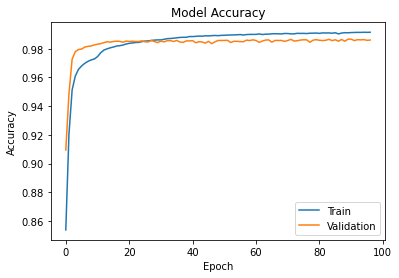

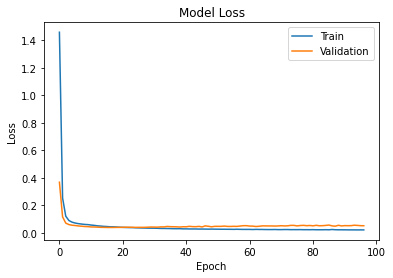

In [7]:
plot_history(history)

In [8]:
unet.evaluate(test_images, test_masks);

510/510 [==============================] - 6s 12ms/sample - loss: 0.0348 - accuracy: 0.9902


### Training model using images with simple data augmentations as well as distortions

In [ ]:
def apply_random_distortion_to_all(function, images, params_for_images={}):
    distorted_images = []

    for image in images:
        params_for_image = {}
        for param, val_range in params_for_images.items():
            params_for_image[param] =  np.random.uniform(*val_range)
            
        distorted_images.append(function(image, **params_for_image))
    
    return np.array(distorted_images)

train_images_added_gaussian = apply_random_distortion_to_all(add_gaussian, train_images, {"amplitude": (0, 500)})
val_images_added_gaussian   = apply_random_distortion_to_all(add_gaussian, val_images  , {"amplitude": (0, 500)})
test_images_added_gaussian  = apply_random_distortion_to_all(add_gaussian, test_images , {"amplitude": (0, 500)})
train_images_added_gaussian_noise = apply_random_distortion_to_all(add_gaussian_noise, train_images, {"mean": (0, 0), "sigma": (0, 50)})
val_images_added_gaussian_noise   = apply_random_distortion_to_all(add_gaussian_noise, val_images  , {"mean": (0, 0), "sigma": (0, 50)})
test_images_added_gaussian_noise  = apply_random_distortion_to_all(add_gaussian_noise, test_images , {"mean": (0, 0), "sigma": (0, 50)})

In [ ]:
train_images = np.append(train_images, train_images_added_gaussian      , axis=0)
train_images = np.append(train_images, train_images_added_gaussian_noise, axis=0)
train_masks  = np.repeat(train_masks , 3                                , axis=0)
val_images   = np.append(val_images  , val_images_added_gaussian        , axis=0)
val_images   = np.append(val_images  , val_images_added_gaussian_noise  , axis=0)
val_masks    = np.repeat(val_masks   , 3                                , axis=0)
test_images  = np.append(test_images , test_images_added_gaussian       , axis=0)
test_images  = np.append(test_images , test_images_added_gaussian_noise , axis=0)
test_masks   = np.repeat(test_masks  , 3                                , axis=0)

print(f'Training set contains {len(train_images)} images.')
print(f'Validation set contains {len(val_images)} images.')
print(f'Test set contains {len(test_images)} images.')

In [ ]:
# Setting up parameters used for training
number_epochs = 200
batch_size = 8
steps_per_epoch = np.ceil(len(train_images)/batch_size).astype(np.uint)
early_stopping = EarlyStopping(patience=80, verbose=1)
model_checkpoint = ModelCheckpoint(filepath=model_retrained_save_path, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)

# Building Unet model.
unet = model.unet(images_shape, show_summary=False)

In [ ]:
# Training
history = unet.fit(train_images, train_masks, validation_data = (val_images, val_masks), batch_size = batch_size, epochs=number_epochs, callbacks=[early_stopping, model_checkpoint])

In [ ]:
plot_history(history)

In [ ]:
unet.evaluate(test_images, test_masks);